**Task-1: setup google colab gpu runtime environment**

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.1 MB/s 
     |████████████████████████████████| 58 kB 8.2 MB/s 
     |████████████████████████████████| 376 kB 59.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6b5712c6d784bbdd944d8b8bd1635aaec1e6e6a4fb9f2ae3c8b1a0d10b7702a4
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1b3031d3fa416e9d08ba42852070c3f2ac5d74a298956897d97ea6aa78611e6e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

**Download dataset**

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


**importing libraries**

In [ ]:
import sys
sys.path.append("/content/Human-Segmentation-Dataset-master")

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

**setup configurations**

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'
EPOCHS=20
LR=0.003
IMG_SIZE=320
BATCH_SIZE=15
ENCODER='timm-efficientnet-b1'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[10]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

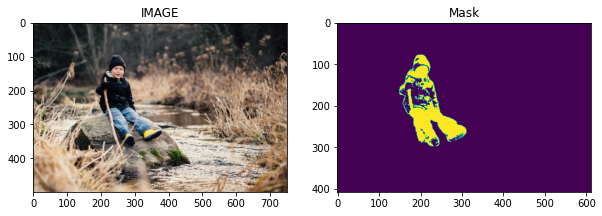

In [ ]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('Mask')
ax2.imshow(mask)

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

**Augmentation functions**

In [ ]:
#!pip install -q --force-reinstall albumentations==1.0.2
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE),A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)])
def get_val_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)])

**Create custom Dataset**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)   #(h,w,c)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']
    #(h,w,c)->(c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255
    mask=torch.round(torch.Tensor(mask)/255)

    return image,mask





In [ ]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_val_augs())
print(f"train_size:{len(trainset)}")
print(f"valid_size:{len(validset)}")

train_size:232
valid_size:58


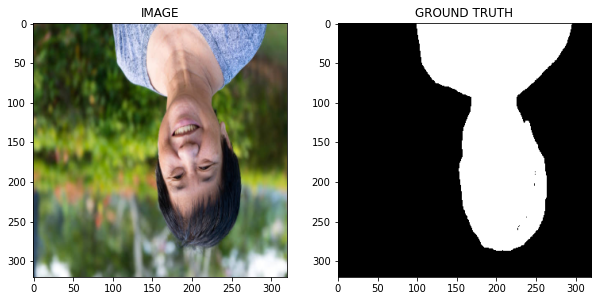

In [ ]:
idx=3
image,mask=trainset[idx]
helper.show_image(image,mask)


**Load dataset into batches**

In [ ]:
from torch.utils.data  import DataLoader
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valueloader=DataLoader(validset,batch_size=BATCH_SIZE)
print(f'total no of batches in trainloader:{len(trainloader)}');
print(f'total no of batches in valueloader:{len(valueloader)}');

total no of batches in trainloader:16
total no of batches in valueloader:4


In [ ]:
for image,mask in trainloader:
  break
print(f'one batch image shape:{image.shape}')
print(f'one batch mask shape:{mask.shape}')

one batch image shape:torch.Size([15, 3, 320, 320])
one batch mask shape:torch.Size([15, 1, 320, 320])


**create segmentation model**

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
from torch.nn.modules.loss import BCEWithLogitsLoss
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  
  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=BCEWithLogitsLoss()(logits,masks)
      logits=loss1+loss2

    return logits


In [ ]:
model=SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

**create train and validation function**

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0
  for images,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)
    optimizer.zero_grad()
    loss=model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  return total_loss/(len(data_loader))


In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)
      loss=model(images,masks)
      total_loss+=loss.item()
  return total_loss/(len(data_loader))
  

**Train Model**

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)


In [ ]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(valueloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('saved model')
    best_vallid_loss=valid_loss
  print(f'Epoch:{i+1} trainloss:{train_loss} valid_loss={valid_loss}')
  

100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


saved model
Epoch:1 trainloss:0.742055993527174 valid_loss=3.820818781852722


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


saved model
Epoch:2 trainloss:0.37180097308009863 valid_loss=0.4237983524799347


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


saved model
Epoch:3 trainloss:0.3174619683995843 valid_loss=0.31302937120199203


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


saved model
Epoch:4 trainloss:0.32058372907340527 valid_loss=0.24269354715943336


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


saved model
Epoch:5 trainloss:0.26837862096726894 valid_loss=0.2432241588830948


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


saved model
Epoch:6 trainloss:0.2628448810428381 valid_loss=0.22767411172389984


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


saved model
Epoch:7 trainloss:0.18528787605464458 valid_loss=0.24797401577234268


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


saved model
Epoch:8 trainloss:0.17929430911317468 valid_loss=0.2133062183856964


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


saved model
Epoch:9 trainloss:0.17619750276207924 valid_loss=0.2971339412033558


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


saved model
Epoch:10 trainloss:0.21631300076842308 valid_loss=0.32617632299661636


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


saved model
Epoch:11 trainloss:0.19739742344245315 valid_loss=0.3128650188446045


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


saved model
Epoch:12 trainloss:0.20427235774695873 valid_loss=0.22204811498522758


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


saved model
Epoch:13 trainloss:0.18242090195417404 valid_loss=0.22057490795850754


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


saved model
Epoch:14 trainloss:0.15577753307297826 valid_loss=0.1880871094763279


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


saved model
Epoch:15 trainloss:0.14487631060183048 valid_loss=0.20945925638079643


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


saved model
Epoch:16 trainloss:0.12736702989786863 valid_loss=0.19532054290175438


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


saved model
Epoch:17 trainloss:0.1387428413145244 valid_loss=0.21187883242964745


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


saved model
Epoch:18 trainloss:0.13531735260039568 valid_loss=0.17775877192616463


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


saved model
Epoch:19 trainloss:0.11452930560335517 valid_loss=0.18521579541265965


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

saved model
Epoch:20 trainloss:0.1793063939549029 valid_loss=0.2801312170922756


**Inference**

In [ ]:
idx=9
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))  #(c,h,w)  -->(1,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1;

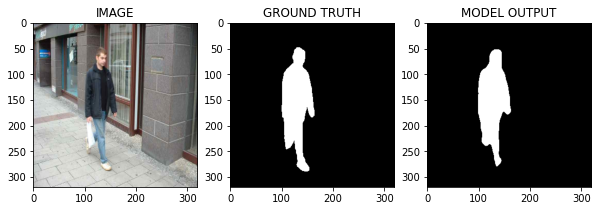

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))